# Capstone Module 20.1 — Initial Report & EDA (Network Intrusion Detection)



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [20]:
DATASET_PATH = r"/content/drive/MyDrive/Berk_CapStone/dataset"
print("Loading dataset files...")

all_files = sorted(glob.glob(os.path.join(DATASET_PATH, "*.csv")))
print("Found files:", len(all_files))

if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")

def read_one_csv(path, sample_frac=None):
    df = pd.read_csv(path, encoding="cp1252", low_memory=False)
    df.columns = df.columns.str.strip()  # keep original but trimmed
    if sample_frac is not None and 0 < sample_frac < 1:
        df = df.sample(frac=sample_frac, random_state=42)
    return df

df_list = []
for f in all_files:
    print("Reading:", os.path.basename(f))
    try:
        # If Colab memory is tight, set sample_frac=0.2 (20%) temporarily
        df_list.append(read_one_csv(f, sample_frac=None))
    except Exception as e:
        print("Error:", f, e)

full_df = pd.concat(df_list, ignore_index=True)
print("Full dataset shape:", full_df.shape)
full_df.head()


Loading dataset files...
Found files: 7
Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: Monday-WorkingHours.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: Tuesday-WorkingHours.pcap_ISCX.csv
Reading: Wednesday-workingHours.pcap_ISCX.csv
Full dataset shape: (2830743, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,33.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80.0,192.168.10.5,55055.0,6.0,7/7/2017 3:30,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443.0,192.168.10.16,46236.0,6.0,7/7/2017 3:30,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,29411.764710,29411.764710,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,31.0,329.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443.0,192.168.10.5,54863.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,32.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [21]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
          .str.replace("/", "_per_", regex=False)
          .str.replace("-", "_", regex=False)
    )
    return df

df = clean_columns(full_df)
print("Example columns:", df.columns[:15].tolist())


Example columns: ['flow_id', 'source_ip', 'source_port', 'destination_ip', 'destination_port', 'protocol', 'timestamp', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean']


In [22]:
print("Rows, Columns:", df.shape)
print("Label values:", df["label"].value_counts().head(15))
print("\nData types (top):")
print(df.dtypes.value_counts())

# Timestamp existence check
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    print("Timestamp range:", df["timestamp"].min(), "→", df["timestamp"].max())


Rows, Columns: (2830743, 85)
Label values: label
BENIGN                        1984531
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Web Attack – Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Data types (top):
float64    80
object      5
Name: count, dtype: int64
Timestamp range: 2017-04-07 01:00:00 → 2017-07-07 12:59:00


In [23]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Show missingness
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("Top missing columns (%):")
print(missing_pct.head(15))

Top missing columns (%):
timestamp                      28.915377
flow_bytes_per_s               10.289242
flow_packets_per_s             10.289242
source_ip                      10.195274
source_port                    10.195274
destination_port               10.195274
destination_ip                 10.195274
flow_duration                  10.195274
protocol                       10.195274
total_backward_packets         10.195274
total_length_of_fwd_packets    10.195274
total_length_of_bwd_packets    10.195274
total_fwd_packets              10.195274
fwd_packet_length_max          10.195274
fwd_packet_length_min          10.195274
dtype: float64


In [24]:
# Drop columns with >50% missing (adjust threshold if needed)
threshold = 50
drop_cols = missing_pct[missing_pct > threshold].index.tolist()
print("Dropping cols >", threshold, "% missing:", drop_cols)

df.drop(columns=drop_cols, inplace=True)

Dropping cols > 50 % missing: []


In [25]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill remaining non-numeric NaNs with "unknown"
cat_cols = [c for c in df.columns if c not in num_cols]
df[cat_cols] = df[cat_cols].fillna("unknown")

print("Missing after fix:", df.isna().sum().sum())

Missing after fix: 0


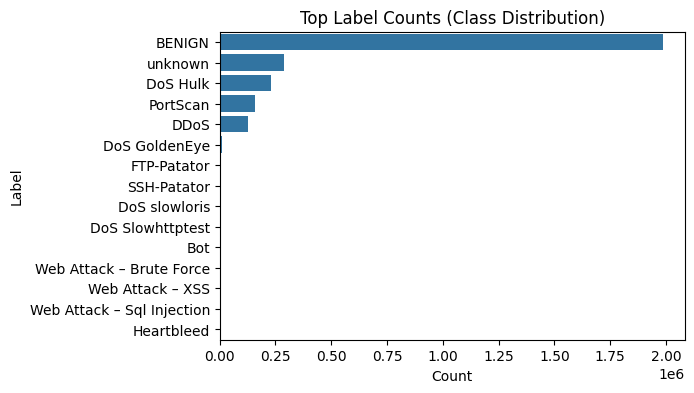

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index[:15])
plt.title("Top Label Counts (Class Distribution)")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

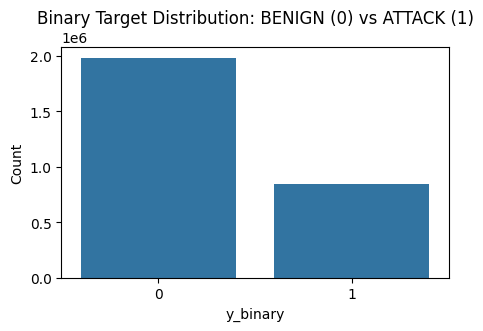

y_binary
0    0.701064
1    0.298936
Name: proportion, dtype: float64


In [27]:

df["y_binary"] = np.where(df["label"].str.upper() == "BENIGN", 0, 1)

plt.figure(figsize=(5,3))
sns.countplot(x="y_binary", data=df)
plt.title("Binary Target Distribution: BENIGN (0) vs ATTACK (1)")
plt.xlabel("y_binary")
plt.ylabel("Count")
plt.show()

print(df["y_binary"].value_counts(normalize=True))

In [28]:
missing_pct = (df.isna().mean() * 100)
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False).head(20)

if len(missing_pct) == 0:
    print("No missing values detected after cleaning.")
else:
    plt.figure(figsize=(6,4))
    missing_pct.sort_values().plot(kind="barh")
    plt.title("Top Features with Missing Values (%)")
    plt.xlabel("Percent Missing")
    plt.show()

No missing values detected after cleaning.


Plotting: ['flow_duration', 'total_fwd_packets', 'total_backward_packets', 'flow_bytes_per_s', 'flow_packets_per_s', 'packet_length_mean', 'packet_length_std', 'syn_flag_count', 'ack_flag_count']


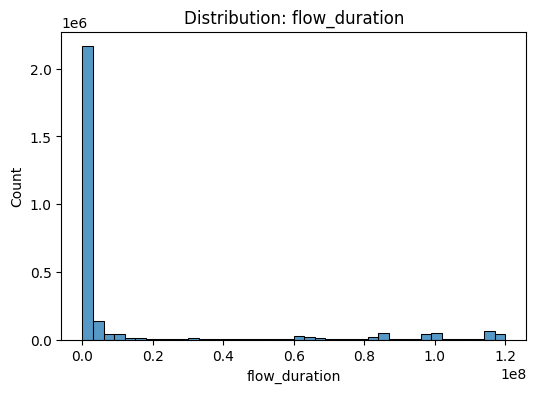

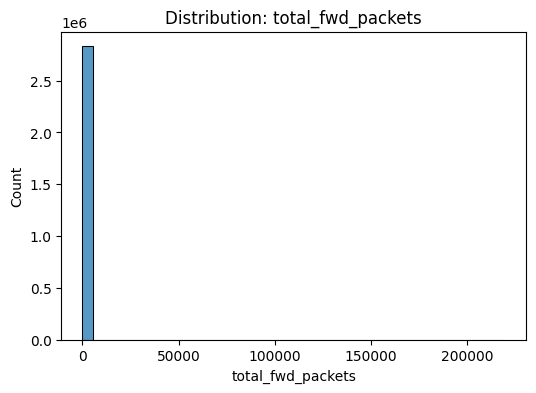

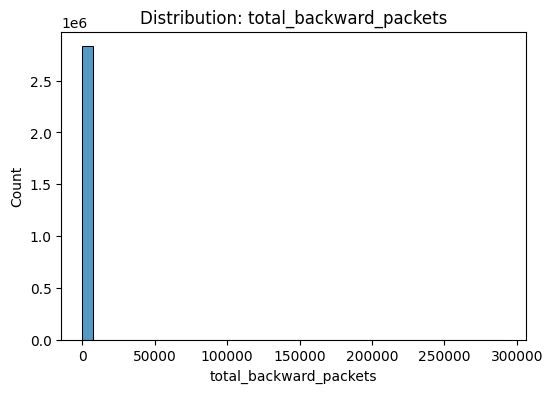

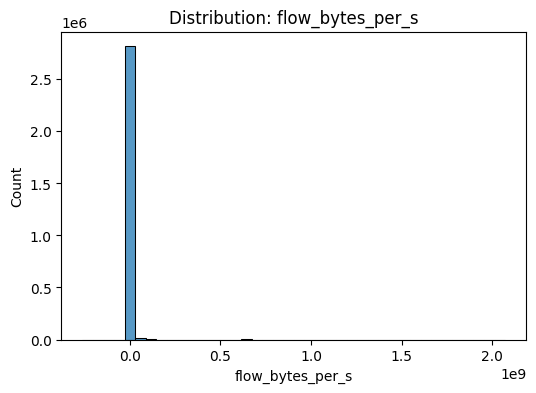

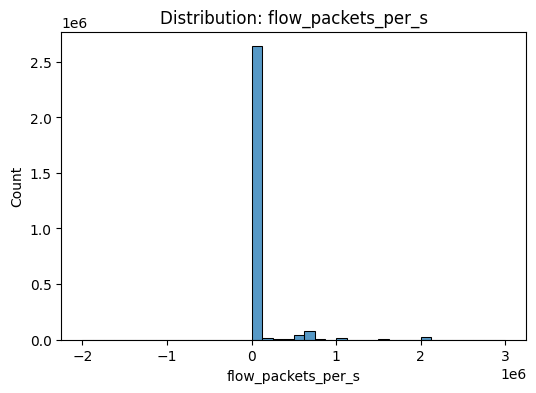

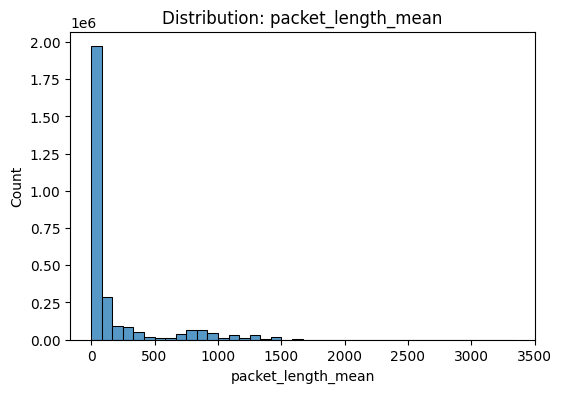

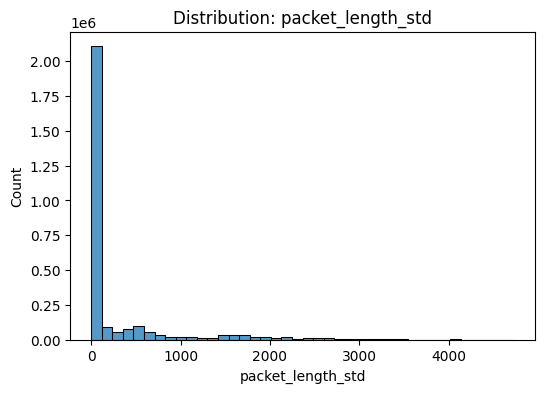

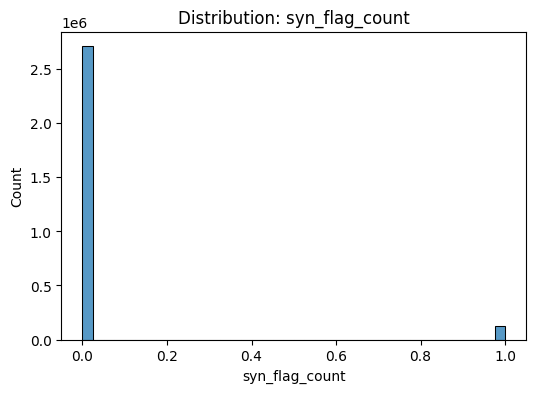

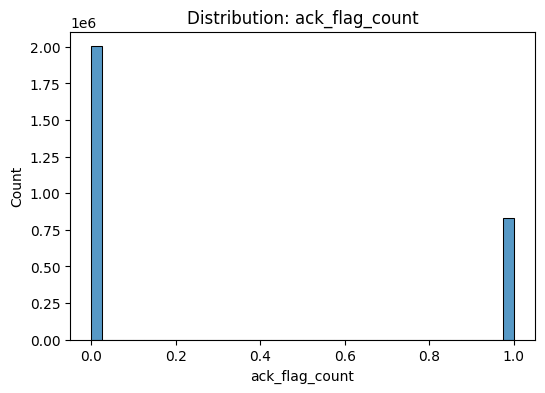

In [29]:
candidate = [c for c in [
    "flow_duration",
    "total_fwd_packets",
    "total_backward_packets",
    "flow_bytes_per_s",
    "flow_packets_per_s",
    "packet_length_mean",
    "packet_length_std",
    "syn_flag_count",
    "ack_flag_count"
] if c in df.columns]

print("Plotting:", candidate)

for c in candidate:
    plt.figure(figsize=(6,4))
    sns.histplot(df[c], bins=40)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

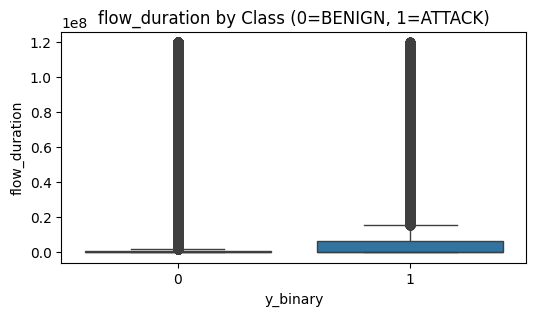

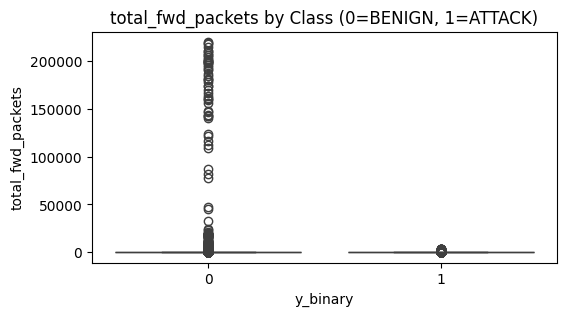

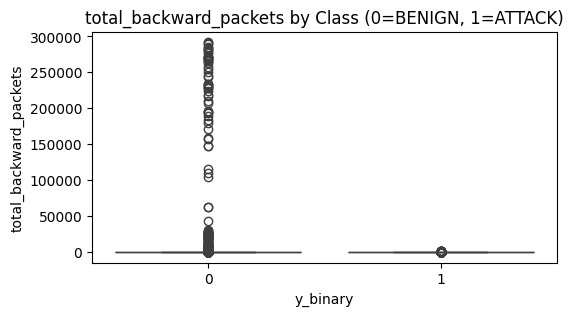

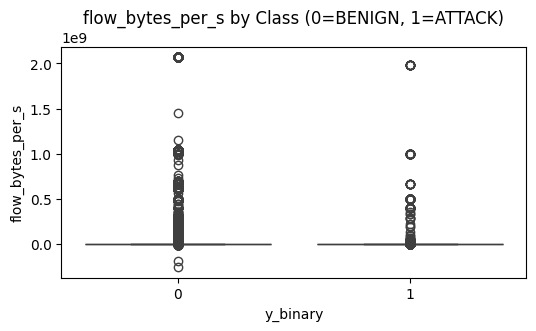

In [30]:
for c in candidate[:4]:  # first 4 is enough
    plt.figure(figsize=(6,3))
    sns.boxplot(x="y_binary", y=c, data=df)
    plt.title(f"{c} by Class (0=BENIGN, 1=ATTACK)")
    plt.xlabel("y_binary")
    plt.ylabel(c)
    plt.show()

In [31]:
# 1) Filter rare classes first (avoid tiny classes like Heartbleed, Sql Injection)
min_samples = 5000
counts = df["label"].value_counts()
keep_classes = counts[counts >= min_samples].index
df_mc = df[df["label"].isin(keep_classes)].copy()

# 2) Stratified downsample: cap each class at N rows
N_PER_CLASS = 30000  # adjust: 10k (fast), 30k (good), 50k (heavy)

df_small = (
    df_mc.groupby("label", group_keys=False)
         .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))
         .reset_index(drop=True)
)

print("Original (filtered):", df_mc.shape)
print("Downsampled:", df_small.shape)
print(df_small["label"].value_counts())

Original (filtered): (2826586, 86)
Downsampled: (185423, 86)
label
BENIGN              30000
DDoS                30000
DoS Hulk            30000
PortScan            30000
unknown             30000
DoS GoldenEye       10293
FTP-Patator          7938
SSH-Patator          5897
DoS slowloris        5796
DoS Slowhttptest     5499
Name: count, dtype: int64


/tmp/ipython-input-367203702.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))


In [32]:
drop_cols = [
    "flow_id", "source_ip", "destination_ip",
    "timestamp", "label"
]

X = df_small.drop(columns=drop_cols, errors="ignore")
X = X.select_dtypes(include=[np.number])

y = df_small["label"]

print("X shape:", X.shape)
print("y classes:", y.nunique())

X shape: (185423, 81)
y classes: 10


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_mc = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_mc.fit(X_train, y_train)
y_pred = rf_mc.predict(X_test)

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

                  precision    recall  f1-score   support

          BENIGN     0.9997    1.0000    0.9999      7500
            DDoS     0.9997    1.0000    0.9999      7500
   DoS GoldenEye     0.9984    0.9992    0.9988      2573
        DoS Hulk     0.9991    0.9993    0.9992      7500
DoS Slowhttptest     0.9985    0.9971    0.9978      1375
   DoS slowloris     0.9972    0.9972    0.9972      1449
     FTP-Patator     1.0000    1.0000    1.0000      1985
        PortScan     1.0000    0.9992    0.9996      7500
     SSH-Patator     1.0000    1.0000    1.0000      1474
         unknown     1.0000    1.0000    1.0000      7500

        accuracy                         0.9995     46356
       macro avg     0.9993    0.9992    0.9992     46356
    weighted avg     0.9995    0.9995    0.9995     46356



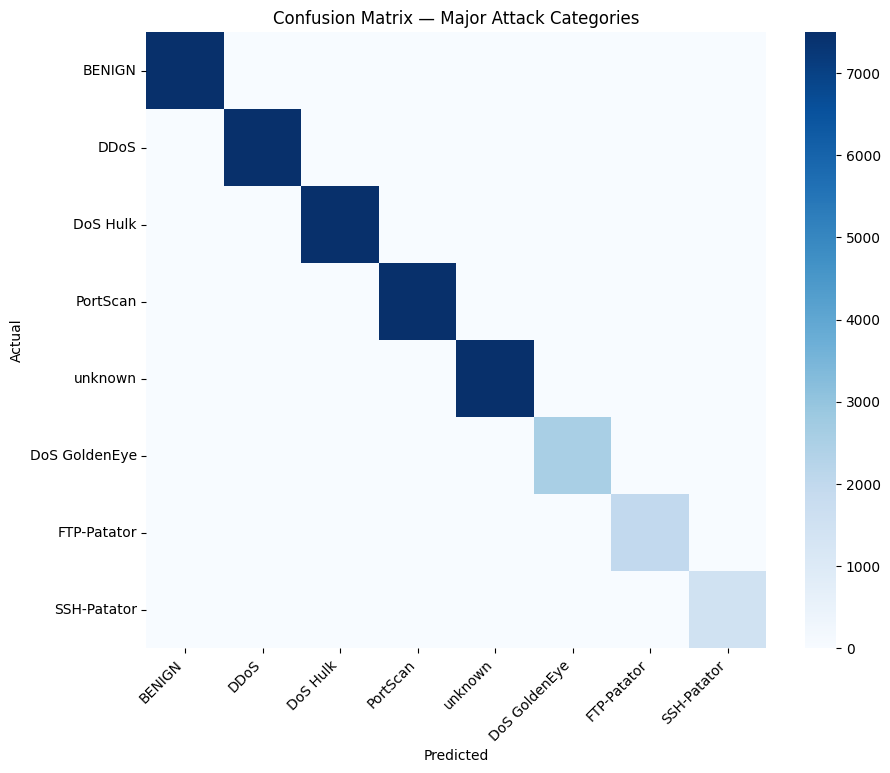

In [36]:
from sklearn.metrics import confusion_matrix

top_classes = y.value_counts().index[:8].tolist()

mask = y_test.isin(top_classes)
cm = confusion_matrix(
    y_test[mask],
    y_pred[mask],
    labels=top_classes
)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=top_classes,
    yticklabels=top_classes
)
plt.title("Confusion Matrix — Major Attack Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

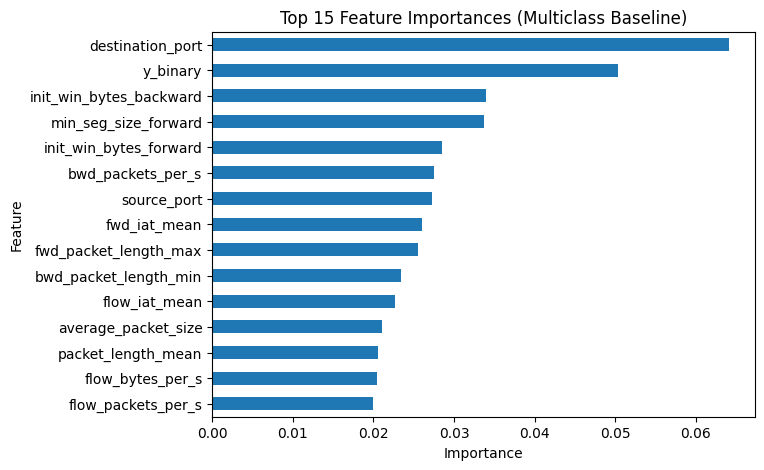

,0
destination_port,0.064074
y_binary,0.050314
init_win_bytes_backward,0.033945
min_seg_size_forward,0.033698
init_win_bytes_forward,0.028514
bwd_packets_per_s,0.027549
source_port,0.027311
fwd_iat_mean,0.026081
fwd_packet_length_max,0.025511
bwd_packet_length_min,0.023424


In [37]:
importances = (
    pd.Series(rf_mc.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
      .head(15)
)

plt.figure(figsize=(7,5))
importances.sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances (Multiclass Baseline)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

importances